We review a physiological interpretation of consonance and dissonant musical sound for human listeners and use a dissonance score to rate different possible triads (combinations of three notes in a scale). This is first done on the conventional scale of 12 equidistant tones in an octave, as well as the Bohlen-Pierce scale.

In [1]:
using Plots
pyplot()

Plots.PyPlotBackend()

## Plomp-Levelt dissonance curve

As a basis of our investigation, we use the Plomp-Levelt dissonance curve as explained in [this article](http://sethares.engr.wisc.edu/consemi.html) by William Sethares.

In [5]:
"Dissonance of sound with two sinusoidal sounds with given frequencies and amplitudes."
function diss(freq1, ampl1, freq2, ampl2)
    s = 0.24 * (freq2 - freq1) / (0.0207 * freq1 + 18.96)
    5.0 * ampl1 * ampl2 * (exp(-3.51 * s) - exp(-5.75 * s))
end

diss

In [19]:
basefreq = 440.0
ratrange = linspace(1.0, 2.0, 100)
otherfreq = basefreq * ratrange
disss = diss.(basefreq, 1.0, otherfreq, 1.0);


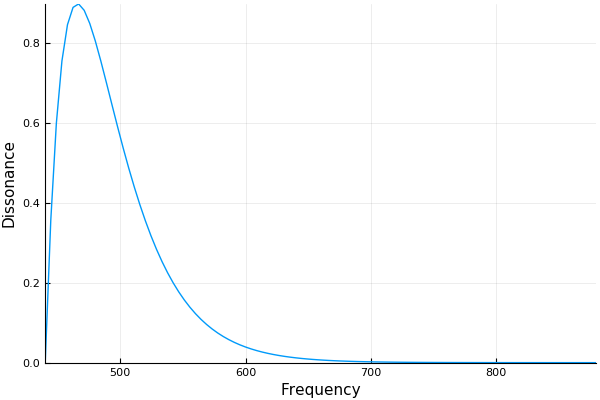

In [23]:
plot(otherfreq, disss, xlabel="Frequency", ylabel="Dissonance", legend=false)

## Dissonance with harmonics

Rather than analyzing dissonance between sinusoidal sounds, we also want to consider sounds with rich harmonics. These have sounds at multiple frequencies with declining amplitudes. When computing the dissonance between two pitches with harmonics, we have to add the dissonance values for all combinations of frequencies.

In [51]:
harmonics(number::Int) = collect(linspace(1.0, number, number))

"Amplitudes for number of harmonics of square signal."
square_harmonics(number::Int) = 1.0 ./ harmonics(number)

"Amplitudes for number of harmonics of triangle signal."
triangle_harmonics(number::Int) = 1.0 ./ harmonics(number).^2

square_harmonics(6)'

1×6 RowVector{Float64,Array{Float64,1}}:
 1.0  0.5  0.333333  0.25  0.2  0.166667